# Trabajo Práctico Nº 2 - Entrenamiento y evaluación de modelos

In [1]:
%matplotlib inline
from itertools import product
from keras.layers import Dense, Activation, Input, Dropout
from keras.models import Sequential
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

/home/abarsotti/Programming/VirtualEnv/MachineLearning/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
# Parámetros para los gráficos.
plt.rcParams['figure.figsize'] = 16, 5
TITLE_FONTSIZE = 18
LABEL_FONTSIZE = 12

In [3]:
# Semillas
TRAIN_SEED = 47
SPLIT_SEED = 27

In [4]:
# Cargar dataset.
dataset = pd.read_csv('data/diamonds.csv', index_col=0)

## Preprocesado

Etiquetamos las instancias según el rango de precio al que pertenezcan.

In [5]:
price_category_labels = [
    'Menor a 1000', 
    'Entre 1000 y 3000', 
    'Entre 3000 y 6000', 
    'Entre 6000 y 10000', 
    'Mayor a 10000'
]
price_limits = [0, 1000, 3000, 6000, 10000, 20000]

dataset['price_category'] = pd.cut(dataset.price, price_limits, labels=price_category_labels).astype(str)

In [6]:
# 60% train, 20% test, 20% validation
train, not_train = train_test_split(dataset, test_size=0.4, random_state=SPLIT_SEED)
validation, test = train_test_split(not_train, test_size=0.5, random_state=SPLIT_SEED)

In [7]:
sets = [('Train', train), ('Test', test), ('Validation', validation)]

In [8]:
def evaluate_model(model, extract_inputs_function, extract_outputs_function):
    for set_name, set_data in sets:
        inputs = extract_inputs_function(set_data)
        outputs = extract_outputs_function(set_data)
        predictions = model.predict(inputs)
        
        if isinstance(model, Sequential):
            dataset = set_data.copy()
            for label_index, label in enumerate(price_category_labels):
                dataset[label] = predictions[:, label_index]

            predictions = dataset[price_category_labels].idxmax(axis=1)

        print(f'{set_name:-^115}')
        print(f'Accuracy: {accuracy_score(outputs, predictions):.5f}')
        print(f'Precision: {precision_score(outputs, predictions, average="macro"):.5f}')
        print(f'Recall: {recall_score(outputs, predictions, average="macro"):.5f}')

        # Mostrar matriz de confusión y matriz de confusión normalizada.
        if isinstance(model, (DecisionTreeClassifier, RandomForestClassifier, GradientBoostingClassifier)):
            cm = confusion_matrix(outputs, predictions)
        else:
            cm = confusion_matrix(outputs, predictions, labels=price_category_labels)
        # Normalizar
        n_cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        
        confusion_matrices = ((cm, 'Matriz de confusión', 'd'), (n_cm, 'Matriz de confusión normalizada', '.2f'))
        
        for index, (matrix, plot_title, number_format) in enumerate(confusion_matrices):
            plt.subplot(1, 2, index + 1)
        
            plt.imshow(
                matrix, 
                cmap=plt.cm.BuPu,
                interpolation='nearest',
            )

            plt.colorbar()
            
            thresh = matrix.max() / 2.
            for i, j in product(range(matrix.shape[0]), range(matrix.shape[1])):
                plt.text(j, i, format(matrix[i, j], number_format),
                         horizontalalignment="center",
                         color="white" if matrix[i, j] > thresh else "black")

            plt.xticks([x for x in range(len(price_category_labels))], price_category_labels, rotation=45)
            plt.yticks([x for x in range(len(price_category_labels))], price_category_labels)
            plt.xlabel('Clase predicha')
            plt.ylabel('Clase correcta')

            plt.title(plot_title)

        plt.show()

In [9]:
def print_predictions_sample(model, extract_inputs_function, extract_outputs_function):
    inputs = extract_inputs_function(validation)
    outputs = extract_outputs_function(validation)
    predictions = model.predict(inputs)
    data = validation.copy()
    
    if isinstance(model, Sequential):
        for label_index, label in enumerate(price_category_labels):
            data[label] = predictions[:, label_index]

        predictions = data[price_category_labels].idxmax(axis=1)
    
    data['predicted_class'] = predictions
    
    if isinstance(model, (DecisionTreeClassifier, RandomForestClassifier, GradientBoostingClassifier)):
        price_category_map = {i + 1: pc for i, pc in enumerate(price_category_labels)}
        data['predicted_class'] = data.predicted_class.map(price_category_map)
        
    cols = ['price', 'price_category', 'predicted_class']
    return data[cols][data.price_category != data.predicted_class].sample(10)

#### Balanceo de los datasets

In [10]:
balance_matrix = pd.DataFrame()
for set_name, set_data in [('Dataset', dataset), *sets]:
    balance_matrix[set_name] = (set_data.price_category.value_counts() / len(set_data) * 100)
balance_matrix.T

,Entre 1000 y 3000,Menor a 1000,Entre 3000 y 6000,Entre 6000 y 10000,Mayor a 10000
Dataset,29.314053,26.926214,22.345198,11.733407,9.681127
Train,29.069336,27.008404,22.389074,11.704363,9.828822
Test,30.181683,26.612903,22.080089,11.688914,9.436411
Validation,29.180571,26.992955,22.478680,11.865035,9.482759


## Métrica de Performance

La métrica de performance elegida para evaluar y comparar los diversos modelos a realizar es **Accuracy**.

Dicha medida expresa en qué porcentaje de casos se efectúa una predicción correcta, y resulta útil en tareas de clasificación como la que intentamos resolver.

Asimismo, el problema abordado no presenta desbalanceos en la información ni es cost-sensitive, dos factores que pueden afectar negativamente a la métrica.

## Feature Engineering

Se intentó aplicar técnicas de feature engineering para mejorar los datos de entrada a los modelos de la siguiente manera:
- Combinar las variables 'x', 'y', 'z' en una única variable 'volume'.
- Convertir la variable 'carat' en no-lineal al elevarla al cuadrado.
- Combinar las variables 'depth' y 'table' en una única variable 'dt'.

Dichos cambios no contribuyeron a mejorar los resultados obtenidos por los distintos modelos presentados.

Además, el dataset no presenta información oculta dentro de las variables ni datos pasados que ameriten la aplicación de otras técnicas de feature engineering.

Por lo tanto, decidimos conservar las columnas originales del dataset para la realización de los modelos.

## Modelos

### Regresión Logística

In [11]:
# Columnas de entrada para Regresión Logística.
ONE_HOT_ENCONDING_COLUMNS = ['cut', 'color', 'clarity']

LR_INPUT_COLUMNS = [
    'carat',
    'depth',
    'table',
    'x',
    'y',
    'z',
    'cut_Fair',
    'cut_Good',
    'cut_Ideal',
    'cut_Premium',
    'cut_Very Good',
    'color_D',
    'color_E',
    'color_F',
    'color_G',
    'color_H',
    'color_I',
    'color_J',
    'clarity_I1',
    'clarity_IF',
    'clarity_SI1',
    'clarity_SI2',
    'clarity_VS1',
    'clarity_VS2',
    'clarity_VVS1',
    'clarity_VVS2',
]


def lr_extract_inputs(dataset):
    inputs = pd.get_dummies(dataset, columns=ONE_HOT_ENCONDING_COLUMNS)
    
    return inputs[LR_INPUT_COLUMNS].values.astype(np.float64)

def lr_extract_outputs(dataset):
    return dataset.price_category.values

In [12]:
lr_model = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', LogisticRegression(random_state=TRAIN_SEED, multi_class='multinomial', solver='newton-cg')),
])

In [13]:
lr_model.fit(
    lr_extract_inputs(train),
    lr_extract_outputs(train),
);

-------------------------------------------------------Train-------------------------------------------------------
Accuracy: 0.90894
Precision: 0.90345
Recall: 0.90220


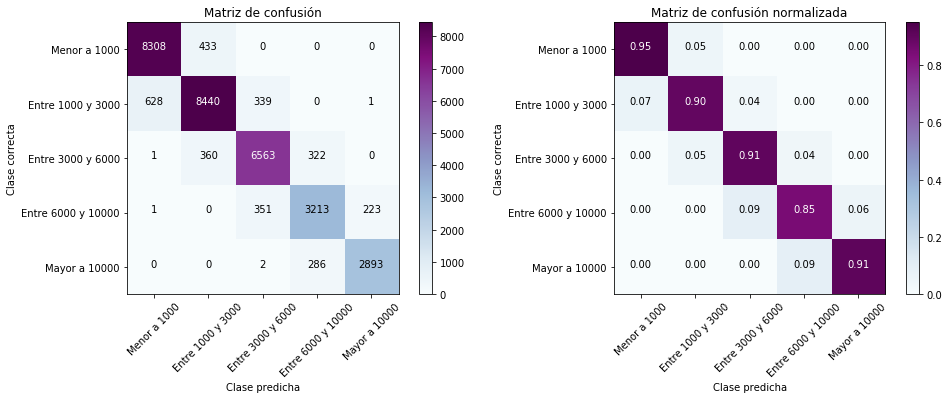

-------------------------------------------------------Test--------------------------------------------------------
Accuracy: 0.90527
Precision: 0.89706
Recall: 0.89815


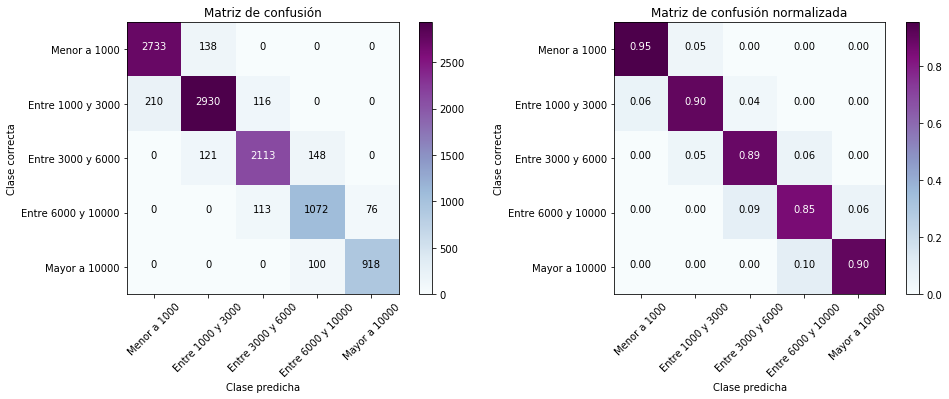

----------------------------------------------------Validation-----------------------------------------------------
Accuracy: 0.90925
Precision: 0.90206
Recall: 0.90166


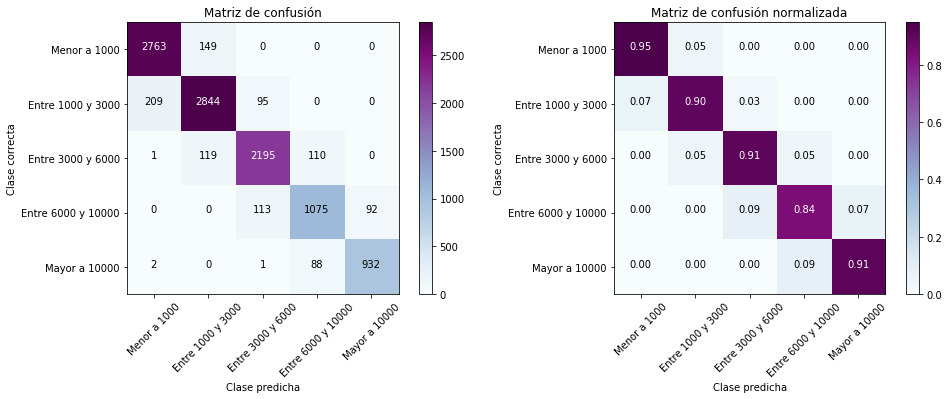

In [14]:
evaluate_model(lr_model, lr_extract_inputs, lr_extract_outputs)

#### Ejemplo de predicciones erróneas

In [15]:
print_predictions_sample(lr_model, lr_extract_inputs, lr_extract_outputs)

,price,price_category,predicted_class
1585,3008,Entre 3000 y 6000,Entre 1000 y 3000
14476,5844,Entre 3000 y 6000,Entre 6000 y 10000
21831,9900,Entre 6000 y 10000,Mayor a 10000
1745,3039,Entre 3000 y 6000,Entre 1000 y 3000
1839,3062,Entre 3000 y 6000,Entre 1000 y 3000
23248,11255,Mayor a 10000,Entre 6000 y 10000
22015,10080,Mayor a 10000,Entre 6000 y 10000
53062,2608,Entre 1000 y 3000,Entre 3000 y 6000
15768,6303,Entre 6000 y 10000,Entre 3000 y 6000
16003,6403,Entre 6000 y 10000,Entre 3000 y 6000


#### Conclusión

El modelo de regresión logística alcanza una accuracy de 91%, aproximadamente. 

Podemos atribuir el buen resultado a que el factor más determinante del precio (y, por ende, de la categoría de precio) es el quilate del diamante. De esta manera, la regresión asigna un coeficiente notablemente mayor a dicha feature, relegando a un segundo plano a las demás y logrando buenos resultados en general.

Finalmente, cabe destacar que las predicciones erróneas se concentran alrededor de la diagonal principal. Esto significa que, si bien la predicción no es correcta, no se encuentra tan alejada del valor real.

### K-NN

In [16]:
K = 4

knn_model = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', KNeighborsClassifier(n_neighbors=K)),
])

In [17]:
knn_model.fit(
    lr_extract_inputs(train),
    lr_extract_outputs(train),
);

-------------------------------------------------------Train-------------------------------------------------------
Accuracy: 0.90650
Precision: 0.90851
Recall: 0.88919


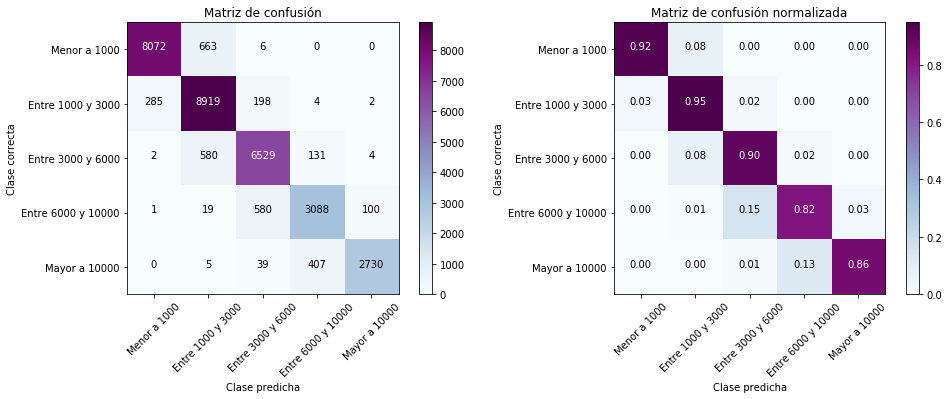

-------------------------------------------------------Test--------------------------------------------------------
Accuracy: 0.84844
Precision: 0.84833
Recall: 0.82527


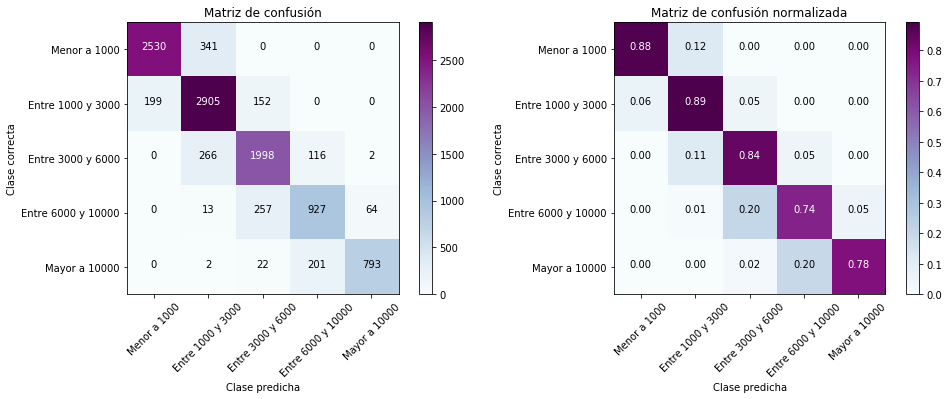

----------------------------------------------------Validation-----------------------------------------------------
Accuracy: 0.85067
Precision: 0.84875
Recall: 0.82798


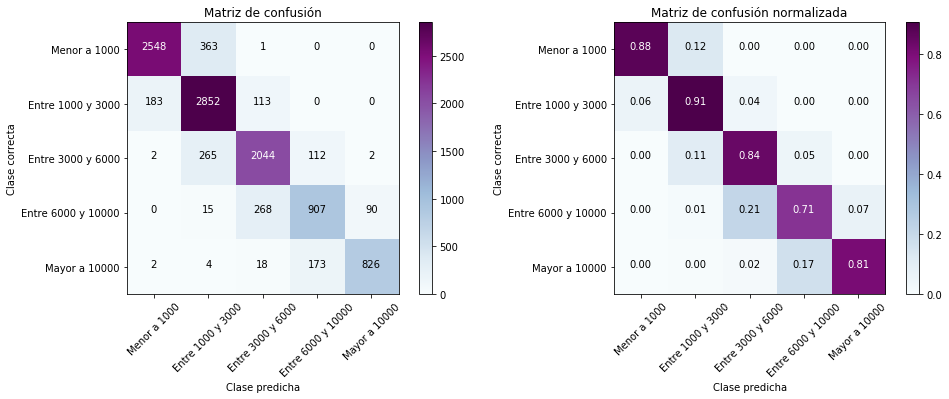

In [18]:
evaluate_model(knn_model, lr_extract_inputs, lr_extract_outputs)

#### Ejemplo de predicciones erróneas

In [19]:
print_predictions_sample(knn_model, lr_extract_inputs, lr_extract_outputs)

,price,price_category,predicted_class
2572,3211,Entre 3000 y 6000,Entre 1000 y 3000
35119,886,Menor a 1000,Entre 1000 y 3000
5673,3884,Entre 3000 y 6000,Entre 1000 y 3000
20172,8624,Entre 6000 y 10000,Entre 3000 y 6000
2837,3268,Entre 3000 y 6000,Entre 6000 y 10000
21267,9417,Entre 6000 y 10000,Mayor a 10000
17267,6912,Entre 6000 y 10000,Entre 3000 y 6000
49065,2058,Entre 1000 y 3000,Entre 3000 y 6000
34733,876,Menor a 1000,Entre 1000 y 3000
38111,1013,Entre 1000 y 3000,Menor a 1000


#### Conclusión

El modelo de kNN alcanza una accuracy de 85%, aproximadamente. 

Observamos nuevamente que las predicciones erróneas, por lo general, se concentran alrededor de la diagonal principal. Como anteriormente se mencionó, esto indica que las predicciones no son correctas, pero no se encuentran tan alejadas del valor real.

Si bien el modelo logra buenos resultados, los mismos son inferiores a los de la regresión logística. Esto puede deberse a la diversidad de tipos de corte, color y claridad que pueden encontrarse en las instancias del dataset dentro de cada categoría de precios. Dicha situación puede generar que instancias que son muy similares en dichas features y que solo se diferencien por el quilate, sean mal clasificadas.

### Árbol de Decisión

In [20]:
DT_INPUT_COLUMNS = [
    'carat',
    'cut',
    'color',
    'clarity',
    'depth',
    'table',
    'x',
    'y',
    'z',
]

def dt_extract_inputs(dataset):
    inputs = dataset.copy()
    
    cut_map = {c: i + 1 for i, c in enumerate(sorted(inputs.cut.unique()))}
    color_map = {c: i + 1 for i, c in enumerate(sorted(inputs.color.unique()))}
    clarity_map = {c: i + 1 for i, c in enumerate(sorted(inputs.clarity.unique()))}
    
    inputs['cut'] = inputs.cut.map(cut_map)
    inputs['color'] = inputs.color.map(color_map)
    inputs['clarity'] = inputs.clarity.map(clarity_map)
        
    return inputs[DT_INPUT_COLUMNS].values

def dt_extract_outputs(dataset):
    outputs = dataset.copy()
    
    price_category_map = {pc: i + 1 for i, pc in enumerate(price_category_labels)}
    outputs['price_category'] = outputs.price_category.map(price_category_map)
    
    return outputs.price_category.values

In [21]:
dt_model = DecisionTreeClassifier(random_state=TRAIN_SEED, max_depth=10)

In [22]:
dt_model.fit(
    dt_extract_inputs(train),
    dt_extract_outputs(train),
);

-------------------------------------------------------Train-------------------------------------------------------
Accuracy: 0.92971
Precision: 0.92059
Recall: 0.92337


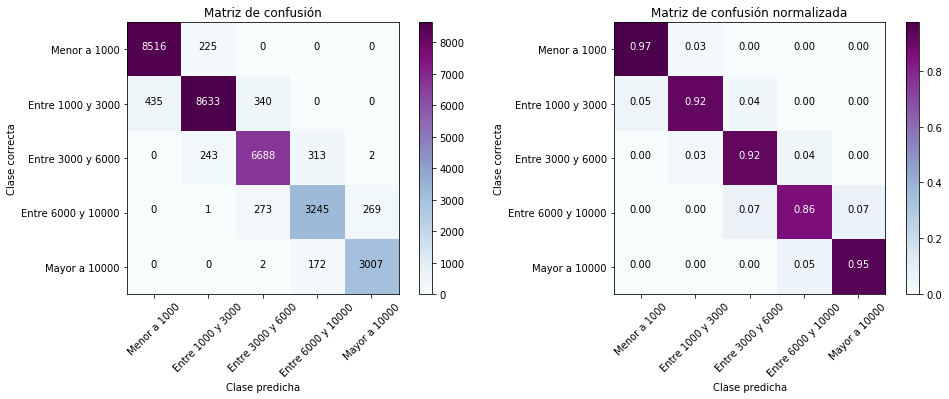

-------------------------------------------------------Test--------------------------------------------------------
Accuracy: 0.89803
Precision: 0.88763
Recall: 0.89321


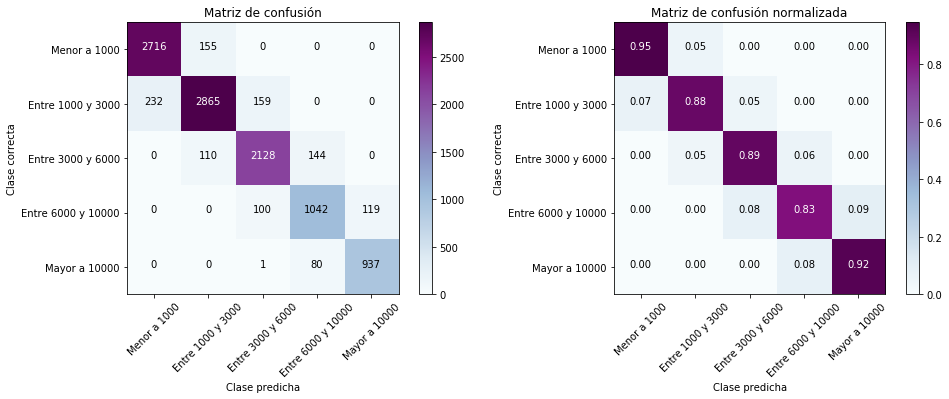

----------------------------------------------------Validation-----------------------------------------------------
Accuracy: 0.90165
Precision: 0.88850
Recall: 0.89336


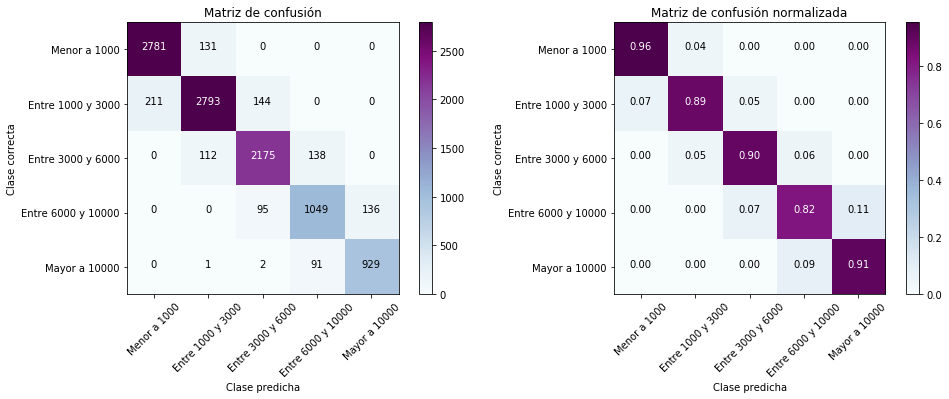

In [23]:
evaluate_model(dt_model, dt_extract_inputs, dt_extract_outputs)

#### Ejemplo de predicciones erróneas

In [24]:
print_predictions_sample(dt_model, dt_extract_inputs, dt_extract_outputs)

,price,price_category,predicted_class
39758,1094,Entre 1000 y 3000,Menor a 1000
25850,14918,Mayor a 10000,Entre 6000 y 10000
37580,990,Menor a 1000,Entre 1000 y 3000
16321,6532,Entre 6000 y 10000,Entre 3000 y 6000
14133,5731,Entre 3000 y 6000,Entre 6000 y 10000
37486,984,Menor a 1000,Entre 1000 y 3000
38483,1031,Entre 1000 y 3000,Menor a 1000
38432,1026,Entre 1000 y 3000,Menor a 1000
3753,3454,Entre 3000 y 6000,Entre 1000 y 3000
12830,5350,Entre 3000 y 6000,Entre 6000 y 10000


#### Conclusión

El modelo de árbol de decisión alcanza una accuracy de 90%, aproximadamente.

Observamos nuevamente que las predicciones erróneas, por lo general, se concentran alrededor de la diagonal principal.

Al examinar el árbol generado por el modelo, notamos que el primer nodo divide a las instancias según el valor de la variable 'carat', lo que indica que es la feature de mayor importancia para el modelo, seguida de 'x' o 'y' en la mayor parte de los casos.

Asimismo, vemos que las variables 'cut', 'color' y 'clarity' suelen verse en la parte inferior del árbol, cerca de los nodos hoja.

### Random Forest

In [25]:
rf_model = RandomForestClassifier(
    n_estimators=30,
    max_features=4,
    random_state=TRAIN_SEED,
)

In [26]:
rf_model.fit(
    dt_extract_inputs(train),
    dt_extract_outputs(train),
);

-------------------------------------------------------Train-------------------------------------------------------
Accuracy: 0.99901
Precision: 0.99910
Recall: 0.99892


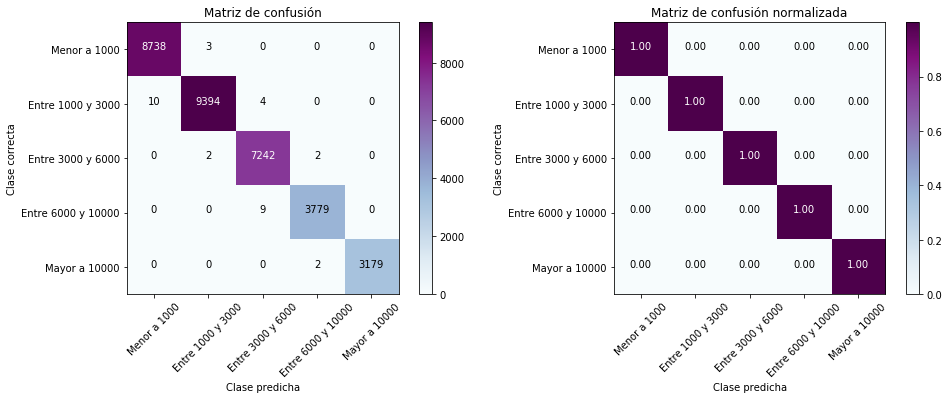

-------------------------------------------------------Test--------------------------------------------------------
Accuracy: 0.91898
Precision: 0.91196
Recall: 0.91331


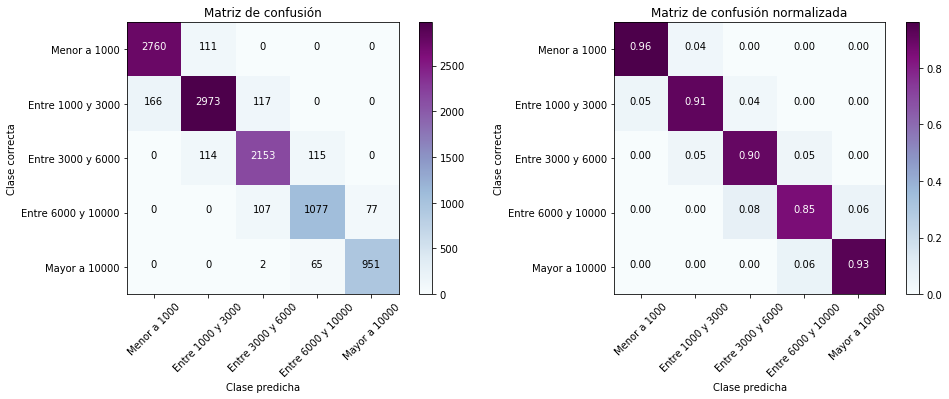

----------------------------------------------------Validation-----------------------------------------------------
Accuracy: 0.92232
Precision: 0.91527
Recall: 0.91537


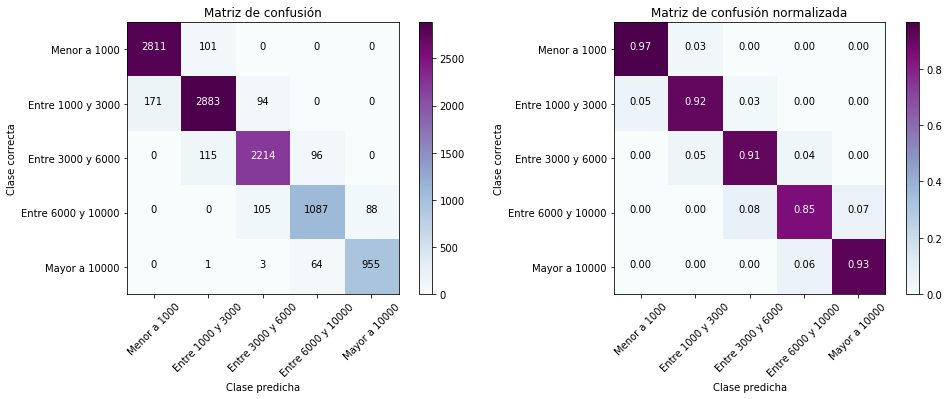

In [27]:
evaluate_model(rf_model, dt_extract_inputs, dt_extract_outputs)

#### Ejemplo de predicciones erróneas

In [28]:
print_predictions_sample(rf_model, dt_extract_inputs, dt_extract_outputs)

,price,price_category,predicted_class
17905,7230,Entre 6000 y 10000,Entre 3000 y 6000
23042,11069,Mayor a 10000,Entre 6000 y 10000
21831,9900,Entre 6000 y 10000,Mayor a 10000
3462,3391,Entre 3000 y 6000,Entre 1000 y 3000
35147,890,Menor a 1000,Entre 1000 y 3000
16613,6639,Entre 6000 y 10000,Entre 3000 y 6000
15000,6041,Entre 6000 y 10000,Entre 3000 y 6000
20553,8870,Entre 6000 y 10000,Mayor a 10000
35131,888,Menor a 1000,Entre 1000 y 3000
22017,10080,Mayor a 10000,Entre 6000 y 10000


#### Conclusión

El modelo de random forest alcanza una accuracy de 92%, aproximadamente.

Observamos nuevamente que las predicciones erróneas, por lo general, se concentran alrededor de la diagonal principal.

La mejora de accuracy respecto al modelo de decision tree deriva de la esencia del modelo random forest: se tiene un mayor número de estimadores, generados aleatoriamente y con muestras aleatorias y diversas de los datos.

### Gradient Boosting

In [29]:
gb_model = GradientBoostingClassifier(
    random_state=TRAIN_SEED,
    max_depth=15,
    n_estimators = 50,
)

In [30]:
gb_model.fit(
    dt_extract_inputs(train),
    dt_extract_outputs(train),
);

-------------------------------------------------------Train-------------------------------------------------------
Accuracy: 0.99981
Precision: 0.99986
Recall: 0.99984


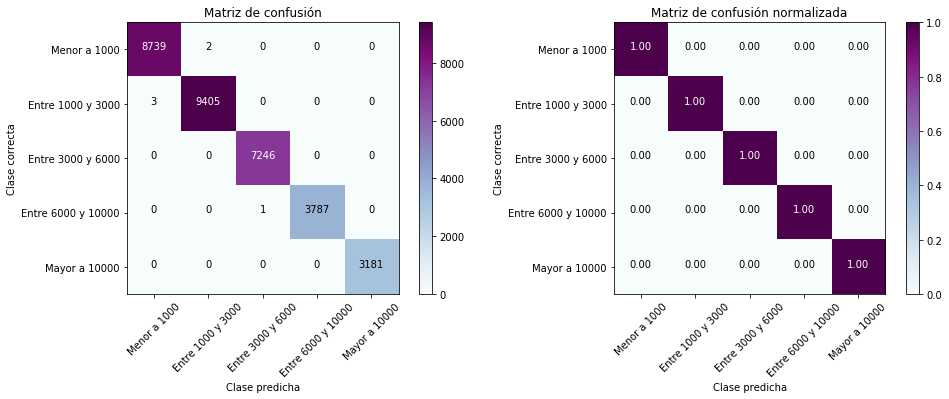

-------------------------------------------------------Test--------------------------------------------------------
Accuracy: 0.91185
Precision: 0.90206
Recall: 0.90379


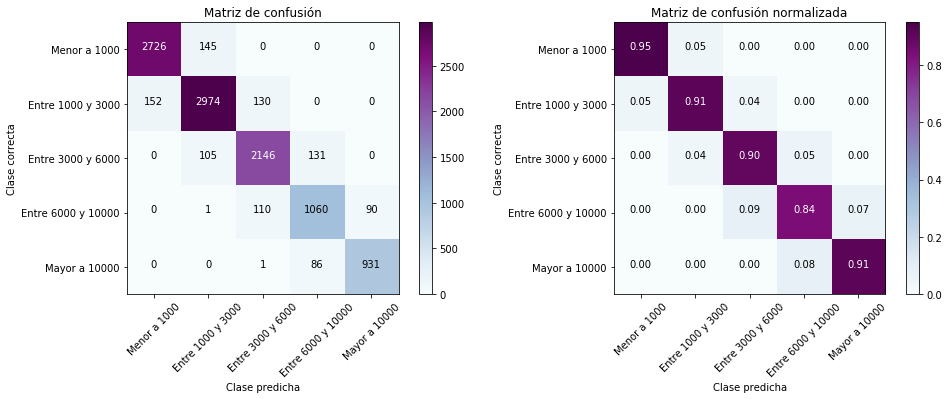

----------------------------------------------------Validation-----------------------------------------------------
Accuracy: 0.92000
Precision: 0.91027
Recall: 0.91193


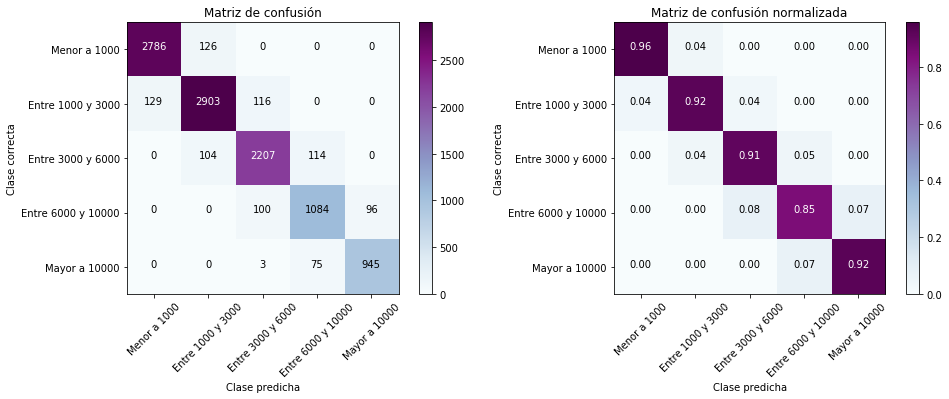

In [31]:
evaluate_model(gb_model, dt_extract_inputs, dt_extract_outputs)

#### Ejemplo de predicciones erróneas

In [32]:
print_predictions_sample(gb_model, dt_extract_inputs, dt_extract_outputs)

,price,price_category,predicted_class
1641,3017,Entre 3000 y 6000,Entre 1000 y 3000
15269,6129,Entre 6000 y 10000,Entre 3000 y 6000
1827,3059,Entre 3000 y 6000,Entre 1000 y 3000
19832,8400,Entre 6000 y 10000,Mayor a 10000
38984,1053,Entre 1000 y 3000,Menor a 1000
38892,1051,Entre 1000 y 3000,Menor a 1000
16782,6685,Entre 6000 y 10000,Entre 3000 y 6000
52147,2470,Entre 1000 y 3000,Entre 3000 y 6000
15080,6061,Entre 6000 y 10000,Entre 3000 y 6000
1270,2948,Entre 1000 y 3000,Entre 3000 y 6000


#### Conclusión

El modelo de gradient boosting alcanza una accuracy de 92%, aproximadamente.

Observamos nuevamente que las predicciones erróneas, por lo general, se concentran alrededor de la diagonal principal.

Los buenos resultados obtenidos por el modelo se fundamentan en sus características principales: estimadores en serie que mejoran progresivamente el resultado del estimador inicial. 

Sin embargo, notamos que el período de entrenamiento del modelo de gradient boosting es mucho mayor al del resto de los modelos presentados anteriormente.

### Red Neuronal

In [33]:
def nn_extract_outputs(dataset):
    return pd.get_dummies(dataset.price_category)[price_category_labels].values.astype(np.float32)

In [34]:
nn_model = Sequential([   
    Dense(100, input_shape=(len(LR_INPUT_COLUMNS), ), activation='tanh'),
    
    Dense(50, activation='tanh'),
    
    Dense(len(price_category_labels), activation='softmax'),
])

nn_model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy',],
)

In [35]:
history = nn_model.fit(
    lr_extract_inputs(train), 
    nn_extract_outputs(train),
    epochs=15,
    batch_size=300,
    validation_data=(
        lr_extract_inputs(test),
        nn_extract_outputs(test),
    )
)

Train on 32364 samples, validate on 10788 samples
Epoch 1/15
32364/32364 [==============================] - 1s 26us/step - loss: 1.2343 - acc: 0.4863 - val_loss: 0.8477 - val_acc: 0.6605
Epoch 2/15
32364/32364 [==============================] - 0s 11us/step - loss: 0.6402 - acc: 0.7855 - val_loss: 0.5001 - val_acc: 0.8210
Epoch 3/15
32364/32364 [==============================] - 0s 12us/step - loss: 0.4371 - acc: 0.8466 - val_loss: 0.3853 - val_acc: 0.8575
Epoch 4/15
32364/32364 [==============================] - 0s 11us/step - loss: 0.3630 - acc: 0.8661 - val_loss: 0.3361 - val_acc: 0.8745
Epoch 5/15
32364/32364 [==============================] - 0s 12us/step - loss: 0.3264 - acc: 0.8728 - val_loss: 0.3081 - val_acc: 0.8793
Epoch 6/15
32364/32364 [==============================] - 0s 11us/step - loss: 0.3143 - acc: 0.8722 - val_loss: 0.2949 - val_acc: 0.8813
Epoch 7/15
32364/32364 [==============================] - 0s 11us/step - loss: 0.3066 - acc: 0.8745 - val_loss: 0.2953 - val_acc

-------------------------------------------------------Train-------------------------------------------------------
Accuracy: 0.88629
Precision: 0.87422
Recall: 0.88116


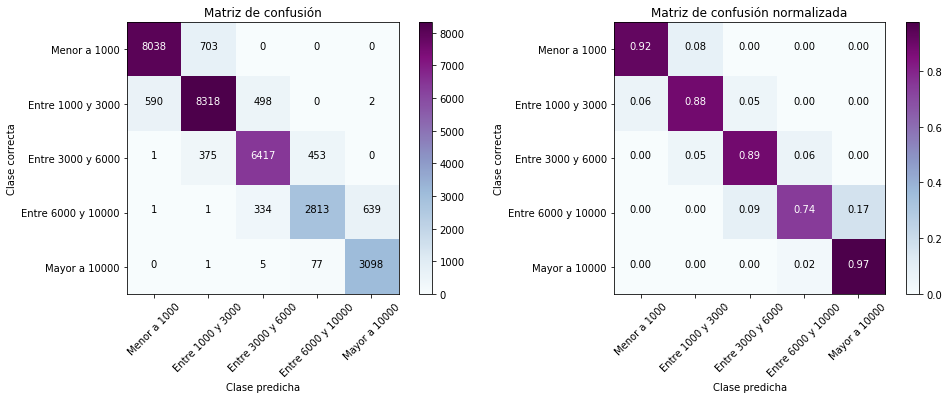

-------------------------------------------------------Test--------------------------------------------------------
Accuracy: 0.88441
Precision: 0.86873
Recall: 0.87933


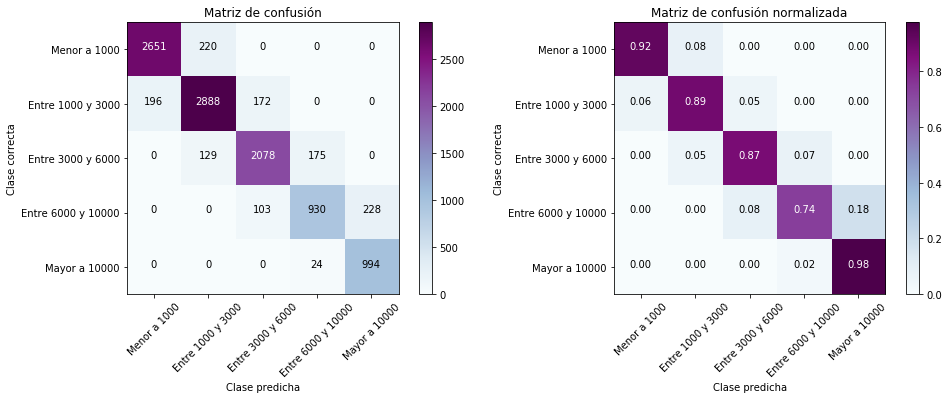

----------------------------------------------------Validation-----------------------------------------------------
Accuracy: 0.88812
Precision: 0.87424
Recall: 0.88173


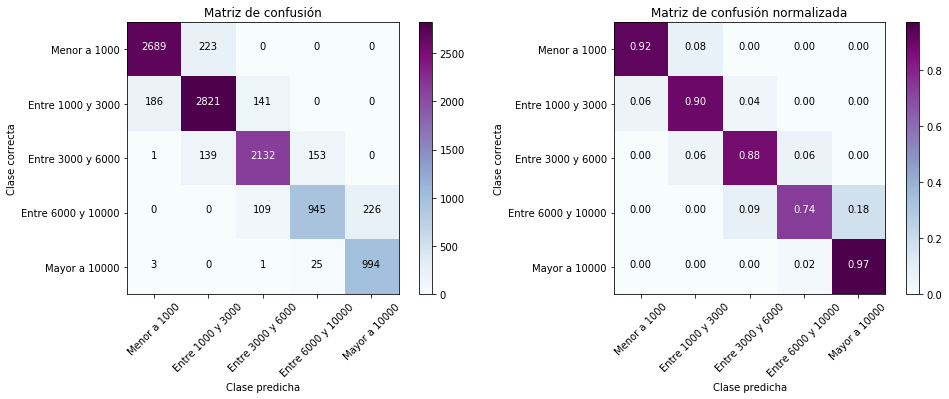

In [36]:
evaluate_model(nn_model, lr_extract_inputs, lr_extract_outputs)

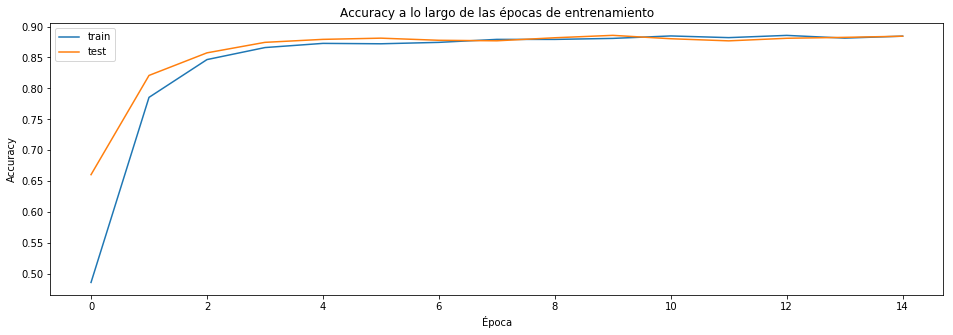

In [37]:
plt.plot(history.history['acc'], label='train')
plt.plot(history.history['val_acc'], label='test')
plt.title('Accuracy a lo largo de las épocas de entrenamiento')
plt.ylabel('Accuracy')
plt.xlabel('Época')
plt.legend(loc='upper left')
plt.show()

#### Ejemplo de predicciones erróneas

In [38]:
print_predictions_sample(nn_model, lr_extract_inputs, lr_extract_outputs)

,price,price_category,predicted_class
36863,958,Menor a 1000,Entre 1000 y 3000
1027,2904,Entre 1000 y 3000,Entre 3000 y 6000
37248,976,Menor a 1000,Entre 1000 y 3000
36499,944,Menor a 1000,Entre 1000 y 3000
20010,8548,Entre 6000 y 10000,Mayor a 10000
19970,8518,Entre 6000 y 10000,Mayor a 10000
21563,9663,Entre 6000 y 10000,Mayor a 10000
14623,5902,Entre 3000 y 6000,Entre 6000 y 10000
21594,9697,Entre 6000 y 10000,Mayor a 10000
18749,7662,Entre 6000 y 10000,Mayor a 10000


#### Conclusión

El modelo de red neuronal alcanza una accuracy de 89%, aproximadamente.

Observamos nuevamente que las predicciones erróneas, por lo general, se concentran alrededor de la diagonal principal.

Si bien se probaron diversas estructuras y funciones de activación, los resultados de las redes neuronales generadas nunca lograron superar el 90-92% de accuracy.

Este fenómeno puede deberse a que existe un número de instancias que no sigue las "reglas" generales de cotización que rigen a la mayor parte de los ejemplos. Sin embargo, no hemos probado tal hipótesis.

## Valor final de la métrica

Si bien los modelos desarrollados logran alcanzar un nivel similar en accuracy, creemos que el mejor de ellos es **Random Forest**. Esto se debe a que es uno de los que obtiene mejores resultados, y entrena relativamente rápido.

Cabe destacar que otra buena opción de modelo sería *Logistic Regression* por su simplicidad. Sin embargo, según las pruebas realizadas, observamos que Random Forest obtiene, en promedio, resultados ligeramente mejores.

Para obtener el valor final de accuracy a informar a un posible cliente, repetiremos múltiples veces los pasos de separación del dataset, construcción del modelo, entrenamiento, predicción con set de validation y cálculo de accuracy sin la utilización del parámetro random_state. De esta forma, conseguiremos una mayor aleatoriedad y variabilidad en cada paso. 

Finalmente, obtendremos un promedio de los resultados de cada iteración para determinar el valor final.

In [39]:
accuracy_list = []
iterations = 50

for i in range(iterations):
    # Separar el dataset sin utilizar random_state para generar grupos aleatorios diversos.
    train, not_train = train_test_split(dataset, test_size=0.4)
    validation, test = train_test_split(not_train, test_size=0.5)
    
    # Crear el modelo sin random_state.
    rf_model = RandomForestClassifier(
        n_estimators=30,
        max_features=4,
    )

    rf_model.fit(
        dt_extract_inputs(train),
        dt_extract_outputs(train),
    )
    
    # Calcular accuracy
    inputs = dt_extract_inputs(validation)
    outputs = dt_extract_outputs(validation)
    predictions = rf_model.predict(inputs)
    
    accuracy_list.append(accuracy_score(outputs, predictions))
    
print(f'Accuracy promedio luego de {iterations} iteraciones: {np.mean(accuracy_list) * 100:.3f}%')

Accuracy promedio luego de 50 iteraciones: 92.054%


El valor final de accuracy del modelo que podría ser informado al cliente es: **92%**.